In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import AI_model
import utils

class Data_process:
    def __init__(self, data_type):
        self.data_type = data_type  # "RML2016.10a" or "RML2016.10b"
        if data_type == 'RML2016.10a':
            self.file_path = f'D:/Research/Dataset_nocode/{self.data_type}/RML2016.10a_dict.pkl'
        elif data_type == 'RML2016.10b':
            self.file_path = f'D:/Research/Dataset_nocode/{self.data_type}/RML2016.10b.dat'

        self.global_comm_round = 20
        self.num_locals = 3


    def data_import(self):
        with open(self.file_path, 'rb') as file:
            pickle_data = pickle.load(file, encoding='latin1')

        data_item = list(pickle_data.items())
        data, SNR, label = [], [], []

        for i in range(len(data_item)):
            data.append(data_item[i][1])
            for j in range(len(data_item[i][1])):
                label.append(data_item[i][0][0])
                SNR.append(data_item[i][0][1])

        label_encoder = LabelEncoder()
        integer_labels = label_encoder.fit_transform(label)
        print(f"RML Dataset Length - 1st (data): {data[0].shape}, 2nd element(SNR): {len(SNR)}, 3rd element(label): {integer_labels}")

        label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Label Mapping:", label_mapping)

        return data, SNR, integer_labels


    def data_process(self, data, SNR, integer_labels, test_ratio=0.2, SNR_threshold=10):

        def one_hot_to_label(one_hot_encoded):
            lst = []
            for i in range(len(one_hot_encoded)):
                lst.append(np.argmax(one_hot_encoded[i]))

            return lst

        def one_hot_encode(labels):
            labels_reshaped = labels.reshape(-1, 1)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_encoded = encoder.fit_transform(labels_reshaped)

            return one_hot_encoded

        OH_label = one_hot_encode(integer_labels)

        if self.data_type == "RML2016.10a":
            X_data = np.array(data).reshape(1000*len(data), 2, 128, 1)
        elif self.data_type == "RML2016.10b":
            X_data = np.array(data).reshape(6000*len(data), 2, 128, 1)
        else:
            print("data_type either RML2016.10a or RML2016.10b")
            return None

        combined_data = list(zip(X_data, OH_label, SNR))
        random.shuffle(combined_data)
        shuffled_x_data, shuffled_y_label, shuffled_SNR = zip(*combined_data)
        x, y, z = np.array(shuffled_x_data), np.array(shuffled_y_label), np.array(shuffled_SNR)

        filtered = [(x_, y_, z_) for x_, y_, z_ in zip(x, y, z) if z_ > SNR_threshold]
        if not filtered:
            raise ValueError("No samples left after filtering with SNR threshold.")

        x, y, z = zip(*filtered)
        x, y, z = np.array(x), np.array(y), np.array(z)  # Convert to NumPy arrays


        shuffled_indices = np.random.permutation(len(x))

        #test_ratio = 0.2  ##########  0.2 Test / 0.8 Train
        split_index = int(len(x) * (1 - test_ratio))

        x_train, x_test = x[shuffled_indices[:split_index]], x[shuffled_indices[split_index:]]
        y_train, y_test = y[shuffled_indices[:split_index]], y[shuffled_indices[split_index:]]
        z_train, z_test = z[shuffled_indices[:split_index]], z[shuffled_indices[split_index:]]

        print(f"x_train shape: {x_train.shape}, y_train: {y.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}")

        return x_train, y_train, x_test, y_test


class MetaLearner:
    def __init__(self, build_model_fn, custom_loss_fn, N_way, input_shape, meta_iters, meta_step_size, alpha):
        self.build_model_fn = build_model_fn
        self.custom_loss_fn = custom_loss_fn
        self.meta_iters = meta_iters
        self.meta_step_size = meta_step_size
        self.num_classes = N_way
        self.input_shape = input_shape
        self.alpha = alpha

        self.model = AI_model.build_model(self.num_classes)
        self.model.build(input_shape=(None, *self.input_shape))
        #self.model.compile(loss=lambda prototypes: self.custom_loss_fn(prototypes, self.alpha), metrics=['accuracy'])
        #self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


    def build_model(self):
        return self.build_model_fn(self.num_classes, self.input_shape)

    def calculate_prototypes(self, embeddings, labels):
        prototypes = []
        for class_idx in range(self.num_classes):
            class_embeddings = embeddings[labels == class_idx]
            prototype = np.mean(class_embeddings, axis=0)
            prototypes.append(prototype)
        return np.array(prototypes)


    def train(self, X_train, y_train, X_test, y_test, get_data_fn, N_way, K_shot):
        accuracies = []

        for meta_iter in range(self.meta_iters):
            frac_done = meta_iter / self.meta_iters
            cur_step_size = (1 - frac_done) * self.meta_step_size
            old_weights = self.model.get_weights()
            train_data, test_data, proto_X, proto_y = get_data_fn(X_train, y_train, X_test, y_test, N_way=N_way, K_shot=K_shot, split=True)

            # Step 1: Get prototypes
            proto_embeddings = self.model.predict(proto_X, verbose=0)
            proto_labels = tf.argmax(proto_y, axis=1)
            prototypes = self.calculate_prototypes(proto_embeddings, proto_labels)

            # Step 2: Set custom loss using current prototypes
            self.model.compile(
                loss=make_custom_loss(prototypes, alpha=self.alpha),
                metrics=['accuracy']
            )

            #self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

            if train_data is None or test_data is None or len(train_data[0]) == 0 or len(test_data[0]) == 0:
                print(f"⚠️ Skipping iteration {meta_iter+1} due to empty train/test data.")
                continue

            # Step 3: Train on one episode
            result = self.model.fit(train_data[0], train_data[1], epochs=100, validation_data=(test_data[0], test_data[1]), verbose=0)
            val_acc = np.max(result.history['val_accuracy'])
            accuracies.append(val_acc)

            print(f"Meta Iter {meta_iter+1}/{self.meta_iters} - Val Acc: {val_acc:.4f}, Max: {np.max(accuracies):.4f}")

            # Step 4: Meta-update
            new_weights = self.model.get_weights()
            updated_weights = [
                old + (new - old) * cur_step_size
                for old, new in zip(old_weights, new_weights)
            ]
            self.model.set_weights(updated_weights)

        return accuracies

In [8]:
def cosine_distance(a, b):
    a = tf.math.l2_normalize(a, axis=-1)
    b = tf.math.l2_normalize(b, axis=-1)
    return 1 - tf.reduce_sum(a * b, axis=-1)

def mahalanobis_distance(x, y, cov_inv):
    diff = x - y
    left = tf.matmul(diff, cov_inv)
    dist = tf.reduce_sum(left * diff, axis=-1)
    return dist

'''def calculate_prototypes(embeddings, labels, num_classes):
    """Calculate mean embedding (prototype) for each class."""
    prototypes = []
    for class_idx in range(num_classes):
        class_embeddings = embeddings[labels == class_idx]
        prototype = tf.reduce_mean(class_embeddings, axis=0)
        prototypes.append(prototype)
    return tf.stack(prototypes)'''

def prototype_loss(embedding, labels, prototypes):
    """Compute distance between embedding and true class prototype."""
    distances = tf.norm(embedding[:, None, :] - prototypes[None, :, :], axis=-1)  #L2 dist.
    #distances = tf.reduce_sum(tf.abs(embedding[:, None, :] - prototypes[None, :, :]), axis=-1)  #L1 dist.
    #distances = cosine_distance(embedding[:, None, :], prototypes[None, :, :]) #cosine sim.
    #prototype = tf.math.l2_normalize(tf.reduce_mean(class_embeddings, axis=0), axis=0) => add if dist. is cosine sim.

    class_indices = tf.cast(tf.argmax(labels, axis=-1), tf.int32)
    true_distances = tf.gather_nd(distances, tf.stack([tf.range(tf.shape(distances)[0]), class_indices], axis=1))
    return tf.reduce_mean(true_distances)


def make_custom_loss(prototypes, alpha):
    """
    Return a custom loss function combining cross-entropy and prototype loss.
    This is needed because prototype is fixed per task/episode.
    """
    def loss(y_true, y_pred):
        class_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        proto_loss = prototype_loss(y_pred, y_true, prototypes)
        return alpha * class_loss + (1 - alpha) * proto_loss
    return loss



def get_data(X_train, y_train, X_test, y_test, N_way, K_shot, split=True):
    """
    Prepares a K-shot N-way classification task.
    Assumes y_train and y_test are one-hot.
    """
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    unique_classes = np.unique(y_train)
    selected_classes = np.random.choice(unique_classes, size=N_way, replace=False)

    X_support, y_support = [], []
    X_query, y_query = [], []

    for cls in selected_classes:
        idxs = np.where(y_train == cls)[0]
        np.random.shuffle(idxs)
        if len(idxs) < K_shot * 2:
            print("HERE")
            continue

        support_idxs = idxs[:K_shot]
        query_idxs = idxs[K_shot:K_shot*2]  # equal size query set

        X_support.append(X_train[support_idxs])
        y_support.append(y_train[support_idxs])

        if split:
            X_query.append(X_train[query_idxs])
            y_query.append(y_train[query_idxs])

    X_support = np.concatenate(X_support, axis=0)
    y_support = np.concatenate(y_support, axis=0)

    lb = LabelBinarizer()
    lb.fit(selected_classes)
    y_support_1hot = lb.transform(y_support)

    if split:
        X_query = np.concatenate(X_query, axis=0)
        y_query = np.concatenate(y_query, axis=0)
        y_query_1hot = lb.transform(y_query)

        # Also provide support set again for calculating prototypes
        return (X_support, y_support_1hot), (X_query, y_query_1hot), X_support, y_support_1hot
    else:
        return X_support, y_support_1hot


In [9]:
data, SNR, labels = Data_process("RML2016.10a").data_import()
X_train, y_train, X_test, y_test = Data_process("RML2016.10a").data_process(data, SNR, labels)

RML Dataset Length - 1st (data): (1000, 2, 128), 2nd element(SNR): 220000, 3rd element(label): [9 9 9 ... 3 3 3]
Label Mapping: {np.str_('8PSK'): np.int64(0), np.str_('AM-DSB'): np.int64(1), np.str_('AM-SSB'): np.int64(2), np.str_('BPSK'): np.int64(3), np.str_('CPFSK'): np.int64(4), np.str_('GFSK'): np.int64(5), np.str_('PAM4'): np.int64(6), np.str_('QAM16'): np.int64(7), np.str_('QAM64'): np.int64(8), np.str_('QPSK'): np.int64(9), np.str_('WBFM'): np.int64(10)}
x_train shape: (35200, 2, 128, 1), y_train: (44000, 11), x_test: (8800, 2, 128, 1), y_test: (8800, 11)


In [ ]:
#num_classes = y_test.shape[-1]
k_shot_sample = 10
N_way_class = 5

meta = MetaLearner(
    build_model_fn=AI_model.build_model,                  # Your model builder function
    custom_loss_fn=make_custom_loss,             # Prototype-aware loss generator
    N_way=N_way_class,                     # E.g. 2
    input_shape=X_train.shape[1:],               # E.g. (63,) or (3, 21, 1)
    meta_iters=100,                              # Number of meta-training loops
    meta_step_size=0.001,                          # Reptile meta step
    alpha=0.7                                     # Balancing classification vs prototype loss
)


accuracies = meta.train(
    X_train, y_train, X_test, y_test,
    get_data_fn=get_data,
    N_way=N_way_class, K_shot=k_shot_sample
)

Meta Iter 1/100 - Val Acc: 0.3200, Max: 0.3200


In [ ]:
plt.plot(accuracies)

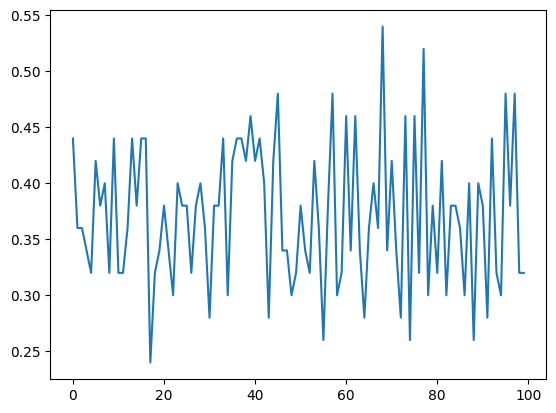

In [5]:
plt.plot(accuracies)